---
# <span style="color:blue">**Classifiers for fine tuning**</span>

In this notebook, the **regularatization strengths** for the **Logistic Regression (one-vs-rest)** and the **Support Vector Classfier (rbf kernel)** are tuned. The fine tuning here is different with respect to the previous method used, for e.g. when looking for the best top k features for the feature selection, as it is peformed with the *GridSearchCV*. The training sample is split into 3 folds using the *StratifiedKFold* cross-validator in order to preserve the percentage of samples for each class. With this strategy, the groups of sets that are created are overlapping, leaking some information in between them. This could have been avoided by using the *StratifiedGroupKFold* but it can not be imported with the current version of sklearn. Nevethertheless, this leaking of information in between the cross-validation does not affect that much the results as we will see on the final evaluation of the unseen, so far, test set.

---
The definition of the positive and negative classes is as following:

**Positive Classes**: any malware type and **NegativeClass**: Benign
 - **TP1**: PartOfAHorizontalScan
 - **TP2**: C&C
 - **TP3**: DDoS
 - **TP4**: Attack
 - **TP5**: PartOfAVerticalScan
 - **TN**: Benign predicted as benign
 - **FP**: Benign predicted as any type of malware
 - **FN**: Any malware type predicted as benign

---

In [1]:
import os
import pandas as pd
import numpy as np
import utils.preprocess as pre
import utils.modeling as md

import seaborn as sns
import matplotlib.pyplot as plt

---
### **Load data and split into sets**
---

In [2]:
from sklearn.model_selection import train_test_split

# Read reduced data with corrected labels
data_df = pd.read_csv(os.path.join('data', 'ioT_data_reduced_labels_corrected.csv'))


# Split data to X, y
X = data_df.drop(['label', 'detailed_label'], axis=1)
y = data_df['detailed_label'].replace({'-': 0,
                                       'PartOfAHorizontalPortScan':1, 
                                       'C&C' : 2,
                                       'DDoS': 3,
                                       'Attack':4,
                                       'PartOfAVerticalPortScan':5
                                      }).values

# Keep 30% of the data for test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print('Train size:', X_tr.shape[0])
print('Test size:', X_te.shape[0])

Train size: 141681
Test size: 60721


---
### **Define pipeline**
---

> As both models needs the features to be scaled, the MinMaxScaler is used for both of them. 

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

# Define the pipeline
pipe = Pipeline([('recover_nulls', pre.RecoverNansPreprocessor()),
                 ('cleaning_preprocessor', pre.CleaningPreprocessor()), 
                 ('categorical_preprocessor', pre.CategoricalPreprocessor(cols_to_dummies = ['protocol', 'conn_state', 'history'])),
                 ('ip_encoding', pre.IPEncodingPreprocessor(ip_to_octets = True)),
                 ('ft', SelectKBest(k=17)),
                 ('scaler', MinMaxScaler()),                 
                 ('clf', None)

])  

---
### **1. LogisticRegression (ovr)**
---

---
#### **1.1 Grid search for regularization strength**
---

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold # preserves the percentage of samples for each class.
from sklearn.linear_model import LogisticRegression


# set parameters
pipe.set_params(clf=LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', class_weight = 'balanced')) 

# Define metrics
metric_names = ['f1_weighted', 'recall_weighted', 'precision_weighted', 'balanced_accuracy']

# Define the grid parameters to search
c = np.logspace(1e-1, 2.7, 50)
grid_param = {'clf__C': c}   

# Define the grid search
gs_logreg = GridSearchCV(estimator=pipe,
                         param_grid=grid_param,
                         scoring=metric_names,
                         refit='balanced_accuracy',
                         cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                         n_jobs=-1,
                         return_train_score=True)   
# Fit on training data
gs_logreg.fit(X_tr, y_tr)

# Get best parameters of the grid search
best_params_logreg = gs_logreg.best_params_
print('Best parameters for one-vs-rest LogisticRegression:', best_params_logreg)

Best parameters for one-vs-rest LogisticRegression: {'clf__C': 392.5342450813759}


---
#### **1.2 Plot validation curves**
---

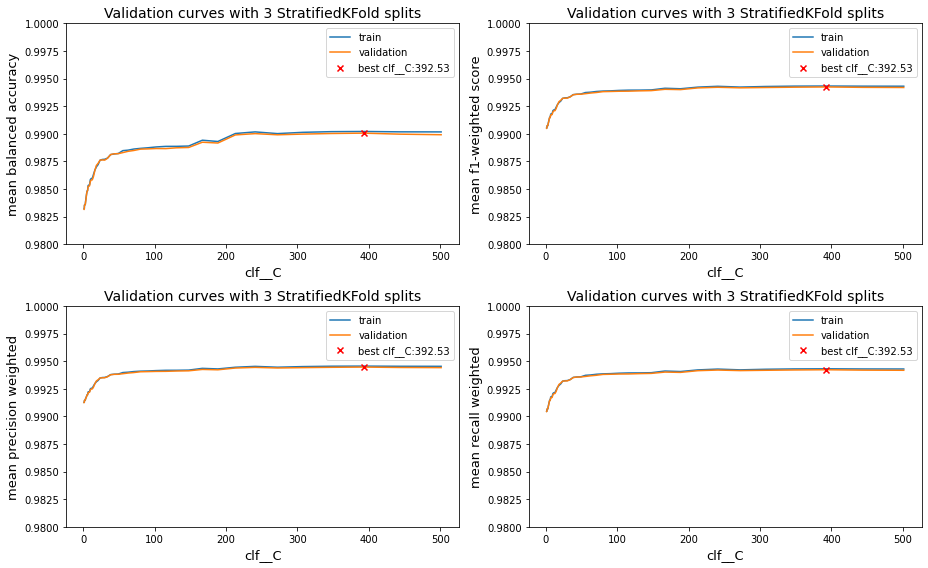

,clf__C,mean_val_acc,std_val_acc,mean_val_f1,std_val_f1,mean_val_precision,std_val_precision,mean_val_recall,std_val_recall
0,392.534245,0.990061,0.000616,0.994243,0.000307,0.994468,0.000301,0.994226,0.000305


In [5]:
# Plot validation curves
gs_results_best_crossval_logreg = md.plot_val_curves(gs_logreg.cv_results_, 
                                                     gs_logreg.best_params_, 
                                                     y_lim_min=0.98, y_lim_max=1,
                                                     best_param_name='clf__C')

# Save results
gs_results_best_crossval_logreg.to_csv(os.path.join('results', 'gs_results_best_crossval_logreg.csv'), index=False)  

> As the regularization strength increases, the mean accuracy is also increasing smootly but within ~1%. In between 300 and 400 we see a plateau. while after the best C there is a small decrease of the validation curve. The best value found is ~392.5. The scores also increased but less than 1%.

---
#### **1.3 Evaluation on test set**
---

In [6]:
# Get predictions and probabilities for test data
y_te_pred_logreg = gs_logreg.best_estimator_.predict(X_te)
y_te_scores_logreg = gs_logreg.best_estimator_.predict_proba(X_te)
y_te_acc_logreg = gs_logreg.best_estimator_.score(X_te, y_te)

print('Test mean accuracy: {:.2f} for regulatization strength: {:.0f}'.format(y_te_acc_logreg, best_params_logreg['clf__C']))

# Save results
test_mean_acc_logreg = ({'model':'LogisticRegression',
                         'test_accuracy':y_te_acc_logreg})
test_mean_acc_logreg = pd.DataFrame(test_mean_acc_logreg, index=[0])
test_mean_acc_logreg.to_csv(os.path.join('results', 'test_mean_acc_logreg.csv'), index=False)  

Test mean accuracy: 0.99 for regulatization strength: 393


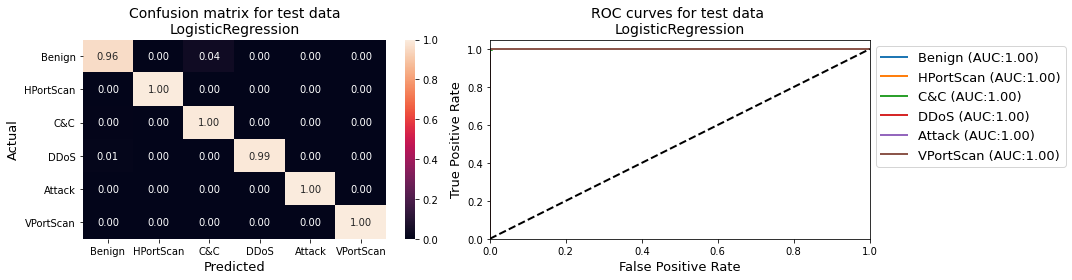




 Classification report for test data (LogisticRegression) 

              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97      6424
   HPortScan       1.00      1.00      1.00     36691
         C&C       0.94      1.00      0.97      4481
        DDoS       1.00      0.99      1.00      4315
      Attack       0.99      1.00      1.00      1788
   VPortScan       1.00      1.00      1.00      7022

   micro avg       0.99      0.99      0.99     60721
   macro avg       0.99      0.99      0.99     60721
weighted avg       0.99      0.99      0.99     60721



In [7]:
cl_report_logreg_test_data = md.get_results_for_test_data(y_te, y_te_pred_logreg, y_te_scores_logreg, 'LogisticRegression')

> The overall performance of the classifier in the unseen data is excellent with an AUC equals to ~1.  Without regularization of the Logistic regression ovr we have seen in the previous test (notebook N.05) that we had 7% of benign entries misclassified as C&C and 2% of C&C entries misclassified as benign. After finding the best regularization strength, for the unseen data, we see ~%4 of benign entries misclassified as C&C and 1% of C&C entries misclassified as benign.

---
### **2. SVC (with rbf kernel)**
---

---
#### **2.1 Grid search for regularization strength**
---

In [8]:
from sklearn.svm import SVC

# set classifier
pipe.set_params(clf=SVC(kernel='rbf', C=1, gamma='auto', probability=True, class_weight = 'balanced'))

c = np.logspace(1e-1, 2.2, 50)
grid_param = {'clf__C': c} 

# Define the grid search
grid_search_svc = GridSearchCV(estimator=pipe,
                               param_grid=grid_param, 
                               scoring=metric_names,
                               refit='balanced_accuracy',
                               cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                               n_jobs=-1,
                               return_train_score=True)   
# Fit on training data
grid_search_svc.fit(X_tr, y_tr)

# Get best parameters of the grid search
best_params_svc = grid_search_svc.best_params_
print('Best parameters for SVM:', best_params_svc)

Best parameters for SVM: {'clf__C': 130.10252169108315}


---
#### **2.2 Plot validation curves**
---

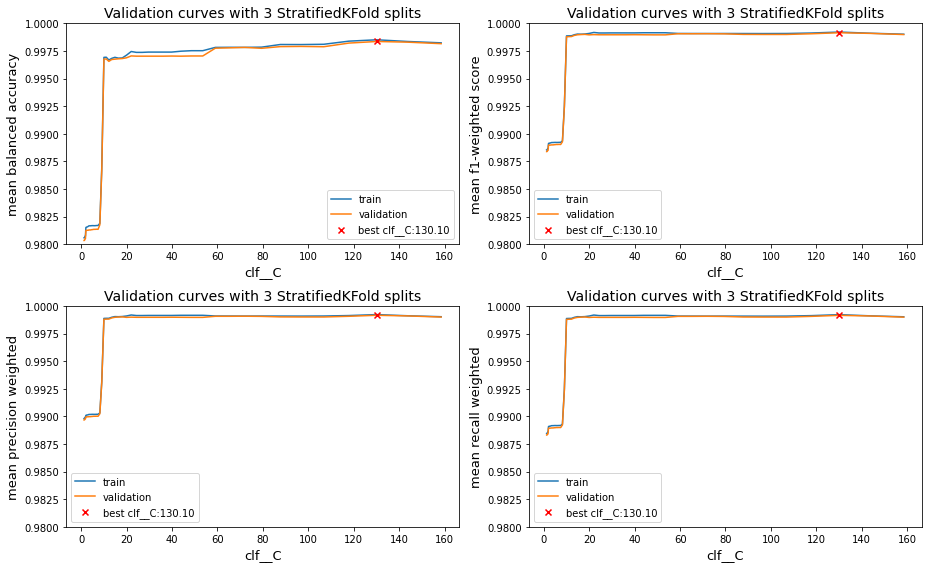

,clf__C,mean_val_acc,std_val_acc,mean_val_f1,std_val_f1,mean_val_precision,std_val_precision,mean_val_recall,std_val_recall
0,130.102522,0.998362,0.000276,0.999153,0.000151,0.999159,0.00015,0.999153,0.000151


In [9]:
# Plot validation curves
gs_results_best_crossval_svc = md.plot_val_curves(grid_search_svc.cv_results_, 
                                                  grid_search_svc.best_params_, 
                                                  y_lim_min=0.98, y_lim_max=1,
                                                  best_param_name='clf__C')

# Save results
gs_results_best_crossval_svc.to_csv(os.path.join('results', 'gs_results_best_crossval_svc.csv'), index=False)  

> For the SVC we see that the regularization strength is about the same from 1 up to about 2.5 and there is a kind of step increase within 1% afterwards where it seems to reach a plateau. The best value found is also close to ~9. 

---
#### **2.3 Evaluation on test set**
---

In [10]:
# Get predictions and probabilities for test data
y_te_pred_svc = grid_search_svc.best_estimator_.predict(X_te)
y_te_scores_svc = grid_search_svc.best_estimator_.predict_proba(X_te)
y_te_acc_svc = grid_search_svc.best_estimator_.score(X_te, y_te)

print('Test mean accuracy: {:.2f} for regulatization strength: {:.0f}'.format(y_te_acc_svc, best_params_svc['clf__C']))

# Save results
test_mean_acc_svc = ({'model':'SVM',
                      'test_accuracy':y_te_acc_svc})
test_mean_acc_svc = pd.DataFrame(test_mean_acc_svc, index=[0])
test_mean_acc_svc.to_csv(os.path.join('results', 'test_mean_acc_svc.csv'), index=False)  

Test mean accuracy: 1.00 for regulatization strength: 130


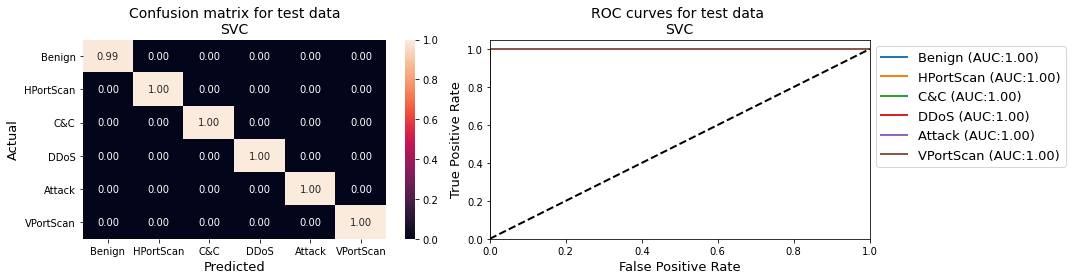




 Classification report for test data (SVC) 

              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00      6424
   HPortScan       1.00      1.00      1.00     36691
         C&C       1.00      1.00      1.00      4481
        DDoS       0.99      1.00      1.00      4315
      Attack       0.99      1.00      1.00      1788
   VPortScan       1.00      1.00      1.00      7022

   micro avg       1.00      1.00      1.00     60721
   macro avg       1.00      1.00      1.00     60721
weighted avg       1.00      1.00      1.00     60721



In [11]:
cl_report_svc_test_data = md.get_results_for_test_data(y_te, y_te_pred_svc, y_te_scores_svc, 'SVC')

> The overall performance of the classifier in the unseen data is excellent with an AUC equals to ~1. Without regularization of the SVC we have seen in the previous test (notebook N.05) that we had ~10% of benign entries misclassified as C&C. After finding the best regularization strength, for the unseen data, we see again about the same percentage of misclassification for the same class. 

---
### **3. Results**
---

---
#### **3.1 Mean validation accuracy before and after fine-tuning of models**
---

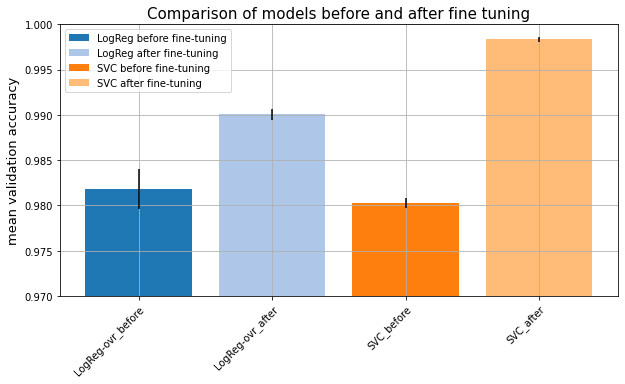

In [13]:
# Import scores from previous test
scores = pd.read_csv(os.path.join('results', 'scores.csv'))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

cm = plt.get_cmap('tab20')
colorrange = np.arange(0,20)/20

plt.bar('LogReg-ovr_before', scores.loc[scores['model']=='LogisticRegression_OvR']['val_balanced_accuracy_mean'].values[0], 
        yerr = scores.loc[scores['model']=='LogisticRegression_OvR']['val_balanced_accuracy_std'].values[0],    
        color=cm(colorrange[0]), label='LogReg before fine-tuning')
plt.bar('LogReg-ovr_after', gs_results_best_crossval_logreg['mean_val_acc'].values[0], 
        yerr = gs_results_best_crossval_logreg['std_val_acc'].values[0],    
        color=cm(colorrange[1]), label='LogReg after fine-tuning')
plt.bar('SVC_before', scores.loc[scores['model']=='SVC']['val_balanced_accuracy_mean'].values[0], 
        yerr = scores.loc[scores['model']=='SVC']['val_balanced_accuracy_std'].values[0],    
        color=cm(colorrange[2]), label='SVC before fine-tuning')
plt.bar('SVC_after', gs_results_best_crossval_svc['mean_val_acc'].values[0], 
        yerr = gs_results_best_crossval_svc['std_val_acc'].values[0],    
        color=cm(colorrange[3]), label='SVC after fine-tuning')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.title('Comparison of models before and after fine tuning',fontsize=15)
plt.ylabel('mean validation accuracy', fontsize=13)
plt.ylim(0.97,1.0)
plt.legend()
plt.grid()
plt.show()

> After fine tuning the mean **validation** accuracy for the Logistic regression was increased by ~1% and for the SVC less than ~0.5%. 

---
#### **3.1 Mean test accuracy after fine-tuning of models**
---

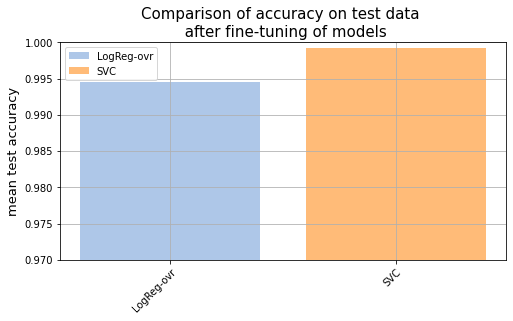

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

cm = plt.get_cmap('tab20')
colorrange = np.arange(0,20)/20

plt.bar('LogReg-ovr', test_mean_acc_logreg['test_accuracy'].values[0], color=cm(colorrange[1]), label='LogReg-ovr')
plt.bar('SVC', test_mean_acc_svc['test_accuracy'].values[0], color=cm(colorrange[3]), label='SVC')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.title('Comparison of accuracy on test data \n after fine-tuning of models',fontsize=15)
plt.ylabel('mean test accuracy', fontsize=13)
plt.ylim(0.97,1.0)
plt.legend()
plt.grid()
plt.show()

> For the **test data** the mean accuracy is ~1% higher than the one obtained in the validation and is close to 99% with both classifiers. 